# Import Packages and Data

In [7]:
# Import Packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

# Open AI & config
import os
import json
import openai
from dotenv import load_dotenv
load_dotenv()

# Clustering
from sklearn.cluster import KMeans

# Dimensionality Reduction
from sklearn.manifold import TSNE

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Similarity Search
from src.vector_similarity import get_embeddings, execute_similarity_search

In [8]:
# Make connections
openai.api_type = "azure"
openai.api_base = "https://crrc-t170-cvx-france.openai.azure.com/"
openai.api_version = "2023-09-15-preview"
openai.api_key = os.getenv("OPENAI_API_KEY")

In [9]:
# Variables

# ============ #
# DATA
# ============ #
filepath = "C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\SETH employee questions\\"

# Input
filename = "SETH-questions-summaries.csv"

# Output

OUTPUT_DIRNAME = filepath
OUTPUT_filename = "SETH-questions-topicClusters.csv"


# Read in data
data = pd.read_csv(str(filepath)+str(filename))

#============#
# Model Config
#============#
k = 3          # Number of clusters to fit ("topics")


In [13]:
# Check data
data.head()

,Unnamed: 0,Topic,Question,summary
0,0,Performance,What leadership behavior changes need to be ma...,Identifying leadership behavior changes to imp...
1,1,Performance,I wanted to ask about unclear messaging coming...,Employee asks about unclear messaging from Sen...
2,2,Performance,"In the last few years, we have heard an overwh...",Questioning sudden deviation from positive mes...
3,3,Performance,The communication on where we missed and what ...,Clarity is needed on what actions are necessar...
4,4,Performance,Want to be respectful for sure but I have hear...,Employees are questioning the effectiveness of...


# Embed Employee Question Summaries

In [14]:
# Generate embeddings from text
embeddings = get_embeddings(data['summary'].tolist())

ValueError: Expected a 1D array, got an array with shape (561, 384)

# Cluster analysis

In [28]:
def train_kmeans_algorithm(data=data, k=k):
    # Create kmeans object
    km = KMeans(n_clusters=k, 
                    max_iter=300, 
                    tol=1e-04, 
                    init='k-means++', 
                    n_init=10, 
                    random_state=42, 
                    algorithm='auto')

    # Fit clusters
    return km.fit(data)

KMeans(n_clusters=30, random_state=42)

# Top observations for each cluster

In [29]:
# Prepare data for similarity search

# Centroid df
cluster_centroids_df = pd.DataFrame()
cluster_centroids_df['Cluster Label'] = range(0,k)
cluster_centroids_df.reset_index(inplace=True, drop=True)


# Observation df
observations_df = pd.DataFrame()
observations_df['Cluster Label'] = km.labels_.tolist()
observations_df['Question'] = data['Question']
observations_df['Topic'] = data['Topic']
observations_df['summary'] = data['summary']
observations_df.reset_index(inplace=True, drop=False)

In [30]:
# Execute Search
response = execute_similarity_search(5,                                 # How many observations per cluster?                   
                                     cluster_centroids_df,              # Cluster DF
                                     km.cluster_centers_.tolist(),      # Cluster embeddings
                                     observations_df,                   # Observations DF
                                     embeddings)                        # Observations embeddings

# Name each cluster

In [31]:
# Read in prompt
description_prompt = json.load(open("prompts/six_word_summary.json"))


def create_summary(data, description_prompt):
    """ Summarize a customer's comments using the GPT API. """
    
    # Prompt is taken from prompt.json
    # Add the customer description to the prompt.
    description_prompt[1]['content'] = ' '.join(data)

    try:
        # Generate the response from the model
        response = openai.ChatCompletion.create(
            engine="gpt-35-turbo",
            temperature=1,
            messages = description_prompt,
            max_tokens=100,
            top_p=0.5,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None
            )
        return response['choices'][0]['message']['content']
    except Exception as e:
        print(f"EXCEPTION {e}\nTHROWN FOR {data}")
        return f"Error : {e}"

In [32]:
# Execute 6 word summary
summaries = []

for i in range(0,k):
    # slice on cluster number
    check = response[response['Cluster Label']==i]
    strings = check['summary'].tolist()

    # Create the summary
    six_word_summary = create_summary(strings, description_prompt)

    # Record the summary
    summaries.append(six_word_summary)

# Add summaries to cluster centroid df
cluster_centroids_df['6 Word Summary'] = summaries

# Dimensionality Reduction

Have to add cluster centroid locations to list of observation embeddings for tSNE to work.  [These will not be used anywhere else.]

In [33]:
# Put values into lists
cluster_locations = km.cluster_centers_.tolist()
# Will add in cluster centers with for loop below
embeddings_with_cluster_centroids = embeddings.tolist()

# Add cluster centers to embeddings list
for i in cluster_locations:
    embeddings_with_cluster_centroids.append(i)

# tSNE object
tsne = TSNE(n_components=2, random_state=0)

# Training tSNE
tsne_data = tsne.fit_transform(embeddings_with_cluster_centroids)
tsne_data_df = pd.DataFrame(tsne_data)

# Format columns for visualization
tsne_data_df = tsne_data_df.rename(columns={0:'x',1:'y'})

# Visualize

In [34]:
# Add coordinates for visualization

# Index values to slice on
low_number = len(tsne_data_df)-k
high_number = low_number + k

# Assign Cluster Centroids Coordinates
x = tsne_data_df['x'].iloc[low_number:high_number].tolist()
y = tsne_data_df['y'].iloc[low_number:high_number].tolist()

## Add Observations Coordinates
observations_df['x'] = tsne_data_df['x'].iloc[0:low_number]
observations_df['y'] = tsne_data_df['y'].iloc[0:low_number]

In [35]:
color_maps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 
'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 
'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 
'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 
'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 
'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 
'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 
'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 
'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 
'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

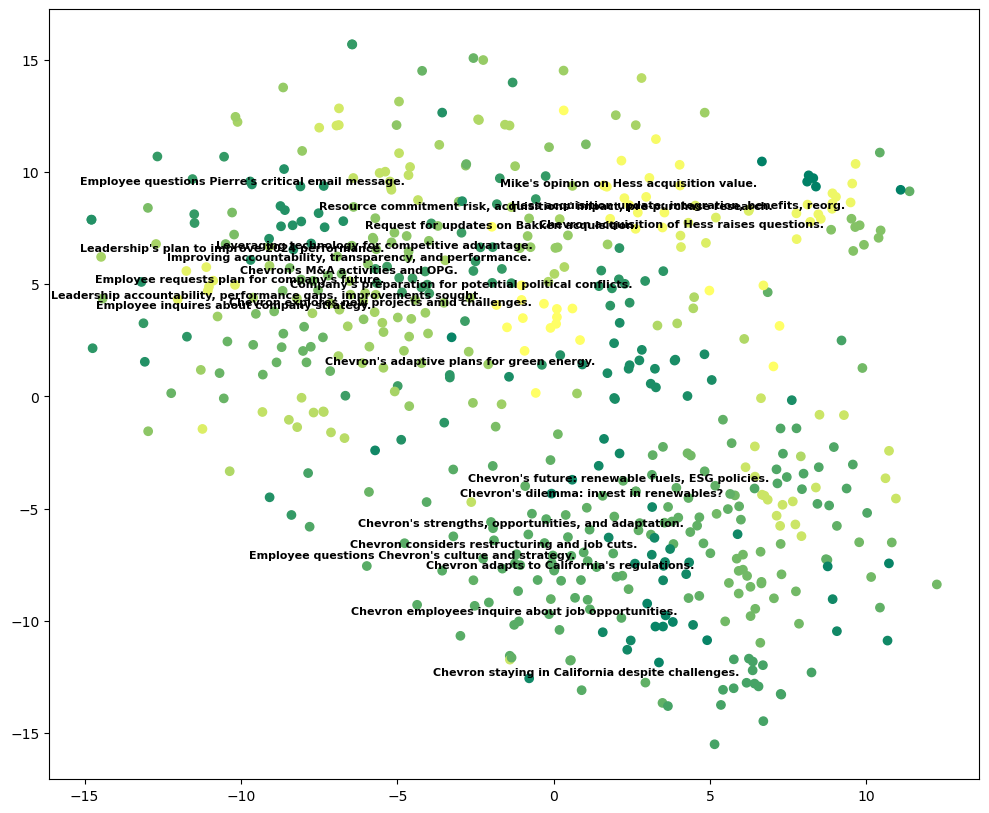

In [36]:
# Plot results
fig = plt.figure()
fig.set_size_inches(12, 10)


# Observations
plt.scatter(
        x= observations_df['x'], y=observations_df['y'],
        c=observations_df['Cluster Label'],
        cmap='summer'
        )



#use for loop to add annotations to each point in plot 
for i, txt in enumerate(cluster_centroids_df['6 Word Summary'].tolist()):
    plt.annotate(txt, (x[i]-10, y[i]), fontsize=8, weight='bold', color='#000000')


# Gold - #d8b04a
# Maroon - #9D021F
# Blue = #0000FF
# Black = #000000

plt.show()

In [38]:
cluster_centroids_df.head(30)

,Cluster Label,6 Word Summary
0,0,Mike's opinion on Hess acquisition value.
1,1,Chevron employees inquire about job opportunit...
2,2,Chevron considers restructuring and job cuts.
3,3,Chevron's adaptive plans for green energy.
4,4,Improving company performance and competitiven...
5,5,Company's preparation for potential political ...
6,6,"Improving accountability, transparency, and pe..."
7,7,Employee requests plan for company's future.
8,8,Chevron staying in California despite challenges.
9,9,"Chevron's future: renewable fuels, ESG policies."


In [39]:
response.head()

,Cluster Label,original_index,Question,Topic,summary,similarity score
0,0,370,I would like Mike to share his views on market...,HESS,Request for Mike's opinion on the market react...,0.628182
1,0,357,What was the driver for the Hess acquisition? ...,HESS,Inquiry about the rationale behind the expensi...,0.622584
2,0,164,Total shareholder return is directly tied to s...,Investor Relations,Questioning why the impact of the Hess acquisi...,0.620014
3,0,145,It seems that we lost quite a bit of market ca...,Investor Relations,Request for an explanation on the decline in m...,0.612573
4,0,148,low $150’s. Wall Street is not acting favorab...,Investor Relations,Strategy team's immediate steps to address Wal...,0.578853


# Save DataFrames

In [40]:
# Make a join df to remove need to drop columns later.  (Adding cluster results to original observations.)
join_df = pd.DataFrame()
join_df['Cluster Label'] = cluster_centroids_df['Cluster Label']
join_df['Topic Name'] = cluster_centroids_df['6 Word Summary']
print(len(join_df))

# Add cluster name to observations dataframe
observations_df = pd.merge(observations_df, join_df, on='Cluster Label', how='left')

30


In [42]:
# Dataset where I performed semantic search of the top k observations against each cluster centroid.
filename_similar_obs = "Observations Close to Topic Clusters.csv"

# Dataset for time series analysis.  Customer Comments + Cluster Info + Created Date
filename_obs_with_cluster_labels = "SETH Questions with Cluster Labels.csv"


response.to_csv(str(filepath)+str(filename_similar_obs))
observations_df.to_csv(str(filepath)+str(filename_obs_with_cluster_labels))

# Appendix

In [19]:
# Use this if you want to export any data

#filepath = 'Models\\XGBoost_classifier\\out\\'
#now = datetime.now()
#current_time = now.strftime("%Y_%m_%d-%H_%M_%S")
#filename_submission = current_time + '_XGBoost_Classifier_Results.csv'
#output_data = y_test

#output_data.to_csv(filepath+filename_submission, sep=',', index = False)

In [20]:
# KMeans Elbow

# from sklearn.metrics import silhouette_score

# silhouette_scores = []
# for k in range(2, 7):
#     km = KMeans(n_clusters=k, 
#                 max_iter=300, 
#                 tol=1e-04, 
#                 init='k-means++', 
#                 n_init=10, 
#                 random_state=42, 
#                 algorithm='auto')
#     km.fit(embeddings)
#     silhouette_scores.append(silhouette_score(embeddings, km.labels_))

# fig, ax = plt.subplots()
# ax.plot(range(2, 7), silhouette_scores, 'bx-')
# ax.set_title('Silhouette Score Method')
# ax.set_xlabel('Number of clusters')
# ax.set_ylabel('Silhouette Scores')
# plt.xticks(range(2, 7))
# plt.tight_layout()
# plt.show()

In [21]:
# Possibly use for dimensionality reduction

"""
import pacmap

# PACMAP
embedding = pacmap.PaCMAP(random_state=42)
X_std_pacmap = embedding.fit_transform(X_std.to_numpy())

for l, c, m in zip(range(0, 3), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o')):
    ax2.scatter(X_std_pacmap[y == l, 0],
                X_std_pacmap[y == l, 1],
                color=c,
                label='cluster %s' % l,
                alpha=0.9,
                marker=m
                )
    
ax1.set_title("PCA Visualization")
ax2.set_title("PACMAP Visualization")

labels = np.unique(km_fit.labels_)
labels = ["cluster "+str(l) for l in labels]
fig.legend(labels, loc='lower center',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)
plt.tight_layout()
plt.show()
"""

'\nimport pacmap\n\n# PACMAP\nembedding = pacmap.PaCMAP(random_state=42)\nX_std_pacmap = embedding.fit_transform(X_std.to_numpy())\n\nfor l, c, m in zip(range(0, 3), cluster_colors[0:km_fit.n_clusters], (\'^\', \'s\', \'o\')):\n    ax2.scatter(X_std_pacmap[y == l, 0],\n                X_std_pacmap[y == l, 1],\n                color=c,\n                label=\'cluster %s\' % l,\n                alpha=0.9,\n                marker=m\n                )\n    \nax1.set_title("PCA Visualization")\nax2.set_title("PACMAP Visualization")\n\nlabels = np.unique(km_fit.labels_)\nlabels = ["cluster "+str(l) for l in labels]\nfig.legend(labels, loc=\'lower center\',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)\nplt.tight_layout()\nplt.show()\n'

In [22]:
# ============ #
#  Slice a df
# ============ #

# def slice_df_on_topic(data, topic):
#     return data[data['Topic__c']==topic]

In [23]:
## PUTS THE STARS BACK ON THE SCATTER PLOT (cluster centroids)

# # Centroids
# plt.scatter(
#         x= cluster_centroids_df['x'], y=cluster_centroids_df['y'],
#         c=cluster_centroids_df['Cluster Label'],
#         # annot=centroids_df_for_search['6 Word Summary'],
#         marker = '*',
#         edgecolors='red',
#         s=250
#         )